In this Page we will provide an example and provide a comparison for the stream based aktive learning stategies related to verification latency. This Notebook uses the delay_wrapper methodes to showcase the diffrent behaiviour of strategies in the concept of verification latency. Each strategie implemented in this project will be representet and can be displayed in comparison for the used Data set. 

In [8]:
import sys
sys.path.append('../..')

import pdb
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import copy

from collections import deque
from skactiveml.classifier import PWC
from skactiveml.stream import RandomSampler, PeriodicSampler
from skactiveml.stream import FixedUncertainty, VariableUncertainty, Split, PAL
from skactiveml.stream.budget_manager import FixedBudget, BIQF
from skactiveml.stream import BaggingDelaySimulationWrapper, ForgettingWrapper, FuzzyDelaySimulationWrapper
from skactiveml.utils import check_random_state

Before the strategy process can start some variables need to be Initialized.
Parameters that are alwayes needed are a random_state, a verification_delay and w_train.
random_state is used to fix the random seed, such that experiments are reapetable
verification_delay decides how long it will take for the label to be acquired

The parameters init_train_length, stream_length and training_size are only needed in this Notebook to generate the Dataset and determin the steam length.
init_train_length describes our training size that is used to learn the chosen classifier before starting the cycle.
stream_length is used to define a data range in that the cylce should operate.
training_size determines the queue size in which the aquiered data will be saved in.


In [9]:
random_state = np.random.RandomState(0)
init_train_length = 10
stream_length = 5000
training_size = 1000
verification_delay = 300

This next method will be used to get the same random state for all strategies to Compare them in ther decision making for the same instances.

In [10]:
def get_randomseed(random_state):
    random_state.randint(2**31-1)

The next block Initializes all date needed for the veryfication latency and al strategies. 
sklearn is used to generate a random dataset with our pre defined sample size and random_state
X represents the Dataset that the aktive learning stategies habe to work on.
y represents the class of each Data in X.
X_init and y_init are used to split the training data out of the steam data.
X_steam and y_steam are the Data steam used in the learning cylce.
These variables are only needed for the al strategies. Sice we will work with verification latency the instances need to tell when they will be available. Therefore we use:
tX and ty to tell with tX when an instance has arrived and ty when it will arrive.
linke X_init, y_init and X_steam, y_steam tX_init, ty_init and tX_stream, ty_stream are used to seperate the initial data from the steam data.

In [11]:
X, center = sklearn.datasets.make_blobs(n_samples=init_train_length + stream_length, centers=30, random_state=get_randomseed(random_state), shuffle=True)
y = center % 2
X_init = X[:init_train_length, :]
y_init = y[:init_train_length]
X_stream = X[init_train_length:, :]
y_stream = y[init_train_length:]
tX = []
ty = []
for c in range(stream_length):
    tX.append(c)
    ty.append(c+verification_delay)
tX = np.array(tX)
ty = np.array(ty)
tX_init = tX[:init_train_length]
ty_init = ty[:init_train_length]
tX_stream = tX[init_train_length:]
ty_stream = ty[init_train_length:]


Afte initializing the Data, last parameters need to be initialized for each delay wrapper. 

missing_label is used to display which label has not arrived
K is used in BaggingDelaySimulationWrapper
w_train will be needed in ForgettingWrapper and describes the window length after witch the old date will be forgotten.
sample_weight determens the weight of each data and should be None or an array with a lenght of X and in range 0 to 1.

In [12]:
missing_label = clf.missing_label
delay_prior = 0.001
K = 2
w_train = training_size
sample_weight = None


Next the query strategies will be saved in a dictionary and later on parsed through so each strategy will be used.
clf is the classifier the cylce will use.
query_strategie_factory generates a new query strategie for each delay wrapper. 

In [13]:
clf_factory = lambda: PWC(classes=[0,1], random_state= get_randomseed(random_state))
query_strategies_factories = {
    # 'VariableUncertainty': VariableUncertainty(clf=clf, random_state=get_randomseed(random_state)),
    'Split': lambda: Split(clf=clf_factory(), random_state=get_randomseed(random_state)),
    'PAL': lambda: PAL(clf=clf_factory(), random_state=get_randomseed(random_state), budget_manager=BIQF( w=256, w_tol=20, budget=None, save_utilities=True))
}

After all variables are Initialized the al cycle can start. It will go through all query strategies defined in query_strategies and use no delay wrapper, ForgettingWrapper, BaggingDelaySimulationWrapper and FuzzyDelaySimulationWrapper on each strategy. After each stream finished the accuracy of each delay wrapper for the selected query strategy will be displayed. Lastly a plot will be displayed that shows the accuracy over all data points in comparison to the other delay wrappers. Some last parameters will be generated in each cycle that are needed for the query strategy. To display and decide the accuracy a new parameter called correct_classifications will be used. It compares the prediction of the classifier for the data to the actual class. Since the verification delay changes how many instances will be purchased the number of acquired instances will also be displayed.

forgetting_wrapper_factory enerates a new forgetting wrapper to combine the simulating wrappers with forgetting. 
X_train and y_train as well as tX_train and ty_train are the queues in which the aquired instances will be saved in. It has the length of the training_size
acquisitions is used to determin if an instance has already arrived or not. For instances that habe not arrived a missing label will be displayed.
correct_classifications is used to decide the accuricy of the strategy and compares the true label of y to the predicted label. after each query strategy the plot will show the progress of accuricy.
y_train_current contains the currently acquired instances of data X and is needed to train the classifier.

Query Strategy:  Split
Delay Wrapper:  None , Accuracy:  0.7622 , Number of acquired instances:  522
Delay Wrapper:  Forgetting , Accuracy:  0.7918 , Number of acquired instances:  522
Delay Wrapper:  BaggingDelaySimulation , Accuracy:  0.7902 , Number of acquired instances:  522
Delay Wrapper:  FuzzyDelaySimulation , Accuracy:  0.794 , Number of acquired instances:  522
Delay Wrapper:  Forgetting + Bagging , Accuracy:  0.7788 , Number of acquired instances:  522
Delay Wrapper:  Forgetting + Fuzzy , Accuracy:  0.7788 , Number of acquired instances:  522


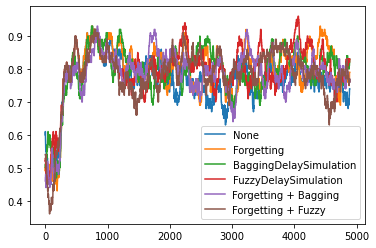

Query Strategy:  PAL
Delay Wrapper:  None , Accuracy:  0.717 , Number of acquired instances:  1144
Delay Wrapper:  Forgetting , Accuracy:  0.7874 , Number of acquired instances:  1148
Delay Wrapper:  BaggingDelaySimulation , Accuracy:  0.7924 , Number of acquired instances:  499
Delay Wrapper:  FuzzyDelaySimulation , Accuracy:  0.7824 , Number of acquired instances:  503
Delay Wrapper:  Forgetting + Bagging , Accuracy:  0.812 , Number of acquired instances:  499
Delay Wrapper:  Forgetting + Fuzzy , Accuracy:  0.8072 , Number of acquired instances:  502


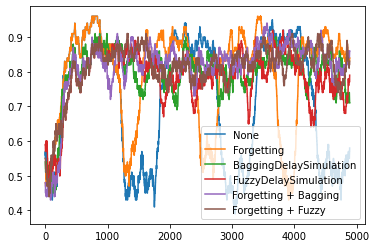

In [14]:
for query_strategy_name, query_strategy_factory in query_strategies_factories.items():
    delay_wrappers_factories = {
        'None': lambda qs: qs,
        'Forgetting': lambda qs: ForgettingWrapper(base_query_strategy=qs, w_train=w_train, random_state=get_randomseed(random_state)),
        'BaggingDelaySimulation': lambda qs: BaggingDelaySimulationWrapper(base_query_strategy=qs, random_state=get_randomseed(random_state), K=K,  delay_prior=delay_prior, clf=clf_factory()),
        'FuzzyDelaySimulation': lambda qs: FuzzyDelaySimulationWrapper(base_query_strategy=qs, random_state=get_randomseed(random_state),  delay_prior=delay_prior, clf=clf_factory())
    }
    delay_wrappers_factories["Forgetting + Bagging"] = lambda qs: delay_wrappers_factories["Forgetting"](delay_wrappers_factories["BaggingDelaySimulation"](qs))
    delay_wrappers_factories["Forgetting + Fuzzy"] = lambda qs: delay_wrappers_factories["Forgetting"](delay_wrappers_factories["FuzzyDelaySimulation"](qs))
    print("Query Strategy: ",query_strategy_name,)
    for delay_wrapper_name, delay_wrapper_factory in delay_wrappers_factories.items():
        clf = clf_factory()
        delay_wrapper = delay_wrapper_factory(query_strategy_factory())
        X_train = deque(maxlen=training_size)
        X_train.extend(X_init)
        y_train = deque(maxlen=training_size)
        y_train.extend(y_init)
        acquisitions = deque(maxlen=training_size)
        acquisitions.extend(np.full(len(y_train),True))
        clf.fit(X_train, y_train)
        tX_train = deque(maxlen=training_size)
        tX_train.extend(tX_init)
        ty_train = deque(maxlen=training_size)
        ty_train.extend(ty_init)
        correct_classifications = []
        count = 0
        for t, (X_cand, y_cand , tX_cand, ty_cand) in enumerate(zip(X_stream, y_stream, tX_stream, ty_stream)):
            y_train_current = np.array([y if ty < tX_cand and a else missing_label for ty, y, a in zip (ty_train, y_train, acquisitions)])
            
            clf.fit(np.array(X_train), np.array(y_train_current))
        
            correct_classifications.append(clf.predict(X_cand.reshape([1, -1]))[0] == y_cand)
            sampled_indices = delay_wrapper.query(X_cand.reshape([1, -1]), X=np.array(X_train), y=np.array(y_train_current), tX=np.array(tX_train), ty=np.array(ty_train), tX_cand=[tX_cand], ty_cand=[ty_cand], return_utilities=False, acquisitions=acquisitions)
            
            tX_train.append(tX_cand)
            ty_train.append(ty_cand)
            X_train.append(X_cand)
            y_train.append(y_cand)

            acquisitions.append((len(sampled_indices) > 0) )
            if len(sampled_indices):
                count += 1
        print("Delay Wrapper: ", delay_wrapper_name, ", Accuracy: ", np.sum(correct_classifications)/stream_length,  ", Number of acquired instances: ", count)
        cumsum_correct_classifications = np.cumsum(correct_classifications)
        smoothing_window_length = 100
        plt.plot((cumsum_correct_classifications[smoothing_window_length:]-cumsum_correct_classifications[:-smoothing_window_length])/smoothing_window_length, label=delay_wrapper_name)
    plt.legend()
    plt.show()